<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Modelo de lenguaje con tokenización por palabras

### Consigna
- Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.
- Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.
- Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.
- Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.


### Sugerencias
- Durante el entrenamiento, guiarse por el descenso de la perplejidad en los datos de validación para finalizar el entrenamiento. Para ello se provee un callback.
- Explorar utilizar SimpleRNN (celda de Elman), LSTM y GRU.
- rmsprop es el optimizador recomendado para la buena convergencia. No obstante se pueden explorar otros.


In [ ]:
import random
import io
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout, GRU, SimpleRNN
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam, RMSprop

### Datos
Como ejemplo se utilizará como corpus un libro de Julio Verne llamado: "Viaje al centro de la tierra".

In [ ]:
# descargar de textos.info
import urllib.request

# Para leer y parsear el texto en HTML de wikipedia
import bs4 as bs

In [ ]:
raw_html = urllib.request.urlopen('https://www.textos.info/julio-verne/viaje-al-centro-de-la-tierra/ebook')
raw_html = raw_html.read()

# Parsear artículo, 'lxml' es el parser a utilizar
article_html = bs.BeautifulSoup(raw_html, 'lxml')

# Encontrar todos los párrafos del HTML (bajo el tag <p>)
# y tenerlos disponible como lista
article_paragraphs = article_html.find_all('p')

article_text = []

for para in article_paragraphs:
    article_text.append(para.text)


In [ ]:
# en article_paragraphs se encuentra el texto de todo el libro
article_paragraphs[1].text

'El domingo 24 de mayo de 1863, mi tío, el profesor Lidenbrock, entró \r\nrápidamente a su hogar, situado en el número 19 de la König‑Strasse, una\r\n de las calles más tradicionales del barrio antiguo de Hamburgo.'

In [ ]:
# cada parrafo lo guardamos en una lista el elemento article_text[2261] es el ultimo parrafo del libro
article_text[2261]

'A partir de aquel día, fue mi tío el más feliz de los sabios, y yo el\r\n más dichoso de los hombres; porque mi bella curlandesa, renunciando a \r\nsu calidad de pupila, ocupó en la modesta casa de König–Strasse el doble\r\n puesto de sobrina y de esposa. No creo necesario añadir que su tío fue \r\nel ilustre profesor Otto Lidenbrock, miembro correspondiente de todas \r\nlas sociedades científicas, geográficas y mineralógicas de las cinco \r\npartes del mundo.'

In [ ]:
len(article_text)

2268

In [ ]:
# eliminamos los parrafos que se generan por la estructura del html de la pagina web como tal
article_text = article_text[1:2262]

In [ ]:
len(article_text)

2261

Consideraremos que cada secuencia para este dataset es un parrafo.

Una de las primeras decisiones que hay que tomar es el tamaño de contexto de tokens máximo que puede consumir el modelo. Este podría ser un hiperparámetro del problema.

Para elegir el tamaño de contexto máximo para este problema se puede explorar el dataset, para ello:
- se consideran las palabras como términos.
- se segmentará el texto de todos los parrafos del dataset y ses explorará la cantidad de términos presentes.



### Elegir el tamaño del contexto

In [ ]:
# Usaremos las utilidades de procesamiento de textos y secuencias de Keras
from tensorflow.keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from tensorflow.keras.preprocessing.text import text_to_word_sequence # equivalente a word_tokenize de nltk
from tensorflow.keras.utils import pad_sequences # se utilizará para padding


In [ ]:
# segmentamos el texto con la utilidad de Keras
segmented_sentences = [text_to_word_sequence(sentence, filters= '¡!"#$%&()*+,-./:;<=>¿?@[\\]^_`{|}~\t\n\r—') for sentence in article_text]

In [ ]:
article_text[3]

'—¡Tan temprano y ya está aquí el señor Lidenbrock! —exclamó la pobre Marta, con arrebol, entreabriendo la puerta del comedor.'

In [ ]:
segmented_sentences[3]

['tan',
 'temprano',
 'y',
 'ya',
 'está',
 'aquí',
 'el',
 'señor',
 'lidenbrock',
 'exclamó',
 'la',
 'pobre',
 'marta',
 'con',
 'arrebol',
 'entreabriendo',
 'la',
 'puerta',
 'del',
 'comedor']

In [ ]:
# calculamos la longitud de cada secuencia
length_sentences = [len(sentence) for sentence in segmented_sentences]

(array([775., 449., 370., 218., 165.,  87.,  76.,  45.,  33.,  17.,  10.,
          7.,   5.,   0.,   2.,   0.,   0.,   0.,   0.,   2.]),
 array([  1. ,  13.5,  26. ,  38.5,  51. ,  63.5,  76. ,  88.5, 101. ,
        113.5, 126. , 138.5, 151. , 163.5, 176. , 188.5, 201. , 213.5,
        226. , 238.5, 251. ]),
 <BarContainer object of 20 artists>)

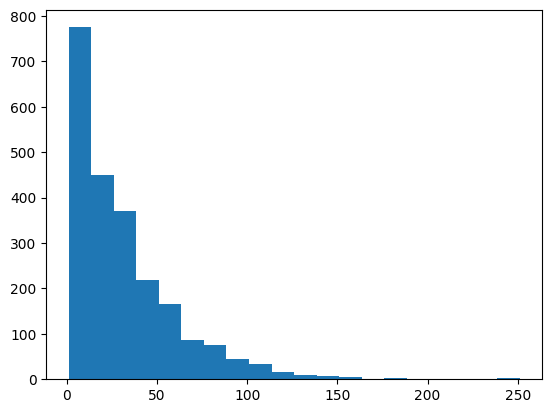

In [ ]:
# podemos ver su distribución
plt.hist(length_sentences,bins=20)

In [ ]:
# a partir de la distribución de longitudes de secuencias elegimos algún criterio
# para determinar el máximo tamaño de contexto. En este caso es un percentil, pero
# otros criterios también pueden ser válidos con la justificación adecuada.
# También puede ser una selección "a mano"

# el -1 es porque el último token será el target
max_context_size = int(np.percentile(length_sentences, 50)-1)

# max_context_size = int(np.ceil(np.mean(length_sentences))) # criterio de media
# max_context_size = int(np.ceil(np.median(length_sentences))) # criterio de mediana
print(f'max_context_size: {max_context_size}')

max_context_size: 22


In [ ]:
max_context_size = 10

###  Tokenizar

In [ ]:
# instanciamos el tokenizador
tok = Tokenizer()

# El tokenizer "aprende" las palabras que se usaran
# Se construye (fit) una vez por proyecto, se aplica N veces (tal cual un encoder)
# El token 0 es reservado y no es asignado. Se utiliza para designar a palabras
# fuera del vocabulario aprendido
tok.fit_on_texts(segmented_sentences)

# Convertimos las palabras a números
# entran palabras -> salen números
tokenized_sentences = tok.texts_to_sequences(segmented_sentences)

In [ ]:
tokenized_sentences[0]

[5,
 1156,
 2160,
 1,
 2928,
 1,
 2929,
 16,
 21,
 5,
 39,
 105,
 2930,
 432,
 6,
 19,
 2161,
 1157,
 7,
 5,
 386,
 2931,
 1,
 2,
 4736,
 15,
 1,
 11,
 1158,
 23,
 4737,
 14,
 2162,
 724,
 1,
 354]

In [ ]:
segmented_sentences[0]

['el',
 'domingo',
 '24',
 'de',
 'mayo',
 'de',
 '1863',
 'mi',
 'tío',
 'el',
 'profesor',
 'lidenbrock',
 'entró',
 'rápidamente',
 'a',
 'su',
 'hogar',
 'situado',
 'en',
 'el',
 'número',
 '19',
 'de',
 'la',
 'könig‑strasse',
 'una',
 'de',
 'las',
 'calles',
 'más',
 'tradicionales',
 'del',
 'barrio',
 'antiguo',
 'de',
 'hamburgo']

### Organizando y estructurando el dataset

En este punto tenemos en la variable `tokenized_sentences` los versos tokenizados. Vamos a quedarnos con un conjunto de validación que utilizaremos para medir la calidad de la generación de secuencias con la métrica de Perplejidad.

In [ ]:
# separaremos el dataset entre entrenamiento y validación.
# `p_val` será la proporción del corpus que se reservará para validación
# `num_val` es la cantidad de secuencias de tamaño `max_context_size` que se usará en validación
p_val = 0.15
num_val = int(np.ceil(len(tokenized_sentences)*p_val/max_context_size))

In [ ]:
# separamos la porción de texto utilizada en entrenamiento de la de validación.
tokenized_sentences_train = tokenized_sentences[:-num_val*max_context_size]
tokenized_sentences_val = tokenized_sentences[-num_val*max_context_size:]

\Vamos a splitear las oraciones que tienen tamaño mayor al contexto máximo, para generarnos más secuencias de entrenamiento. Este paso puede obviarse si el tamaño de contexto máximo es muy grande.

Por ejemplo, si tenemos el texto *La bella y graciosa moza marchóse a lavar la ropa* y nuestro contexto es de 5 palabras, tendremos:

- *La bella y graciosa moza*
- *bella y graciosa moza marchóse*
- *y graciosa moza marchóse a*
- *graciosa moza marchóse a lavar*
- *moza marchóse a lavar la*
- *marchóse a lavar la ropa*

In [ ]:
tok_sent = []

for sent in tokenized_sentences_train:

  # si la secuencia tiene más términos que el tamaño de contexto máximo,
  # armo varias sub-secuencias de tamaño máximo
  if len(sent) > (max_context_size+1):
    extra = len(sent)-(max_context_size+1) + 1
    for i in range(extra):
      tok_sent.append(sent[i:i+max_context_size+1])
  else: # si la secuencia tiene menos términos el tamaño de contexto máximo, dejo la secuencia como está
    tok_sent.append(sent)


In [ ]:
len(tok_sent)

44609

Ahora aumentamos los datos aprovechando que de una secuencia grande se pueden generar varias más pequeñas:

- *La hermosa casa en el prado*
- *La hermosa*
- *La hermosa casa*
- *La hermosa casa en*
- *La hermosa casa en el*
- *La hermosa casa en el prado*

In [ ]:
tok_sent_augm = []

for sent in tok_sent:

  # generamos todas las sub-secuencias
  subseq = [sent[:i+2] for i in range(len(sent)-1)]
  # en esta línea paddeamos al tamaño de contexto máximo
  tok_sent_augm.append(pad_sequences(subseq, maxlen=max_context_size+1, padding='pre'))


In [ ]:
# finalmente concatenamos todas las secuencias en un único array de numpy
train_seqs = np.concatenate(tok_sent_augm, axis=0)


In [ ]:
train_seqs.shape

(443241, 11)

In [ ]:
len(tokenized_sentences_train)

1921

In [ ]:
train_seqs[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    5, 1156],
      dtype=int32)

In [ ]:
# y de aquí sacamos las entradas y los targets que consumirá nuestro sistema en
# tiempo de entrenamiento
X = train_seqs[:,:-1]
y = train_seqs[:,1:]

Nótese que estamos estructurando el problema de aprendizaje como *many-to-many*:

Entrada: secuencia de tokens [$x_0$, $x_1$, ..., $x_N$]

Target: secuencia de tokens [$x_1$, $x_2$, ..., $x_{N+1}$]

De manera que la red tiene que aprender que su salida deben ser los tokens desplazados en una posición y un nuevo token predicho (el N+1).

La ventaja de estructurar el aprendizaje de esta manera es que para cada token de target se propaga una señal de gradiente por el grafo de cómputo recurrente, que es mejor que estructurar el problema como *many-to-one* en donde sólo una señal de gradiente se propaga.

In [ ]:
y.shape

(443241, 10)

In [ ]:
# Palabras del vocabulario
tok.index_word

{1: 'de',
 2: 'la',
 3: 'que',
 4: 'y',
 5: 'el',
 6: 'a',
 7: 'en',
 8: 'no',
 9: 'un',
 10: 'se',
 11: 'las',
 12: 'los',
 13: 'por',
 14: 'del',
 15: 'una',
 16: 'mi',
 17: 'con',
 18: 'me',
 19: 'su',
 20: 'al',
 21: 'tío',
 22: 'pero',
 23: 'más',
 24: 'lo',
 25: 'es',
 26: 'nos',
 27: 'sin',
 28: 'para',
 29: 'sus',
 30: 'qué',
 31: 'como',
 32: 'era',
 33: 'este',
 34: 'había',
 35: 'yo',
 36: 'sobre',
 37: 'esta',
 38: 'si',
 39: 'profesor',
 40: 'hans',
 41: 'mis',
 42: 'le',
 43: 'todo',
 44: 'hasta',
 45: 'después',
 46: 'ni',
 47: 'vez',
 48: 'ya',
 49: 'pues',
 50: 'aquel',
 51: 'dos',
 52: 'cuando',
 53: 'bien',
 54: 'tan',
 55: 'mar',
 56: 'ha',
 57: 'o',
 58: 'sí',
 59: 'agua',
 60: 'dijo',
 61: 'entonces',
 62: 'cual',
 63: 'usted',
 64: 'pies',
 65: 'entre',
 66: 'tierra',
 67: 'poco',
 68: 'nuestra',
 69: 'tiempo',
 70: 'muy',
 71: 'él',
 72: 'ser',
 73: 'hacia',
 74: 'menos',
 75: 'axel',
 76: 'porque',
 77: 'gran',
 78: 'fin',
 79: 'mismo',
 80: 'estas',
 81: 'prec

In [ ]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

10986

In [ ]:
# El índice para cada palabra
# El sistema las ordena de las más populares a las menos populares
print(tok.word_index)

{'de': 1, 'la': 2, 'que': 3, 'y': 4, 'el': 5, 'a': 6, 'en': 7, 'no': 8, 'un': 9, 'se': 10, 'las': 11, 'los': 12, 'por': 13, 'del': 14, 'una': 15, 'mi': 16, 'con': 17, 'me': 18, 'su': 19, 'al': 20, 'tío': 21, 'pero': 22, 'más': 23, 'lo': 24, 'es': 25, 'nos': 26, 'sin': 27, 'para': 28, 'sus': 29, 'qué': 30, 'como': 31, 'era': 32, 'este': 33, 'había': 34, 'yo': 35, 'sobre': 36, 'esta': 37, 'si': 38, 'profesor': 39, 'hans': 40, 'mis': 41, 'le': 42, 'todo': 43, 'hasta': 44, 'después': 45, 'ni': 46, 'vez': 47, 'ya': 48, 'pues': 49, 'aquel': 50, 'dos': 51, 'cuando': 52, 'bien': 53, 'tan': 54, 'mar': 55, 'ha': 56, 'o': 57, 'sí': 58, 'agua': 59, 'dijo': 60, 'entonces': 61, 'cual': 62, 'usted': 63, 'pies': 64, 'entre': 65, 'tierra': 66, 'poco': 67, 'nuestra': 68, 'tiempo': 69, 'muy': 70, 'él': 71, 'ser': 72, 'hacia': 73, 'menos': 74, 'axel': 75, 'porque': 76, 'gran': 77, 'fin': 78, 'mismo': 79, 'estas': 80, 'preciso': 81, 'nada': 82, 'he': 83, 'superficie': 84, 'balsa': 85, 'duda': 86, 'momento'

In [ ]:
# Cantidad de veces quea aparece cada palabra en cada "documento"
# (1 documento = 1 caso de entrada)
print(tok.word_docs)

defaultdict(<class 'int'>, {'la': 1121, 'hamburgo': 20, 'de': 1417, 'mayo': 2, 'situado': 6, '1863': 2, 'tradicionales': 1, '24': 3, 'las': 567, 'del': 520, 'a': 985, 'entró': 2, 'en': 935, 'número': 19, 'una': 517, 'antiguo': 10, 'rápidamente': 17, 'profesor': 171, 'el': 977, 'mi': 569, 'hogar': 3, '19': 2, 'barrio': 3, 'könig‑strasse': 1, 'su': 349, 'más': 314, 'calles': 6, 'lidenbrock': 63, 'tío': 402, 'domingo': 6, 'se': 611, 'pues': 118, 'que': 1055, 'comida': 19, 'excelente': 15, 'criada': 4, 'preocupó': 1, 'retrasado': 1, 'había': 166, 'cocinar': 1, 'apenas': 24, 'empezaba': 4, 'hornillo': 1, 'sobremanera': 1, 'creyendo': 3, 'marta': 24, 'viene': 2, 'hombre': 64, 'pensé': 19, 'san': 6, 'quintín': 1, 'para': 242, 'porque': 78, 'conozco': 3, 'va': 14, 'otro': 56, 'con': 494, '“si': 2, 'menos': 77, 'hambre': 18, 'no': 785, 'paciencia”': 1, '“bueno”': 1, 'mí': 62, 'armar': 1, 'señor': 53, 'ya': 118, 'temprano': 5, 'comedor': 7, 'entreabriendo': 1, 'aquí': 55, 'pobre': 14, 'exclamó':


### Definir el modelo

In [ ]:
model = Sequential()

# la primera capa es de embedding entrenable. Recordar que se puede variar el tamaño
# del embedding a entrenar
model.add(Embedding(input_dim=vocab_size+1, output_dim=30, input_shape=(None,)))

model.add(SimpleRNN(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))
#model.add(Dropout(0.2))
model.add(SimpleRNN(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))
#model.add(GRU(70, return_sequences=True))
#model.add(Dropout(0.2))

#model.add(LSTM(100, return_sequences=True))
#model.add(Dropout(0.2))
#model.add(Dense(70, activation='relu'))

# Predicción de clasificación con softmax
# La salida es del tamaño del vocabulario
model.add(Dense(vocab_size+1, activation='softmax'))


# Clasificación multiple categórica --> loss = categorical_crossentropy
# notar que usamos la versión Sparse para utilizar sólo índices en lugar de OHE
#optimizer = Adam(learning_rate=0.0001)
optimizer = RMSprop(learning_rate=0.001)

model.compile(loss=SparseCategoricalCrossentropy(), optimizer=optimizer, metrics=['accuracy'])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, None, 30)            │         329,610 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_3 (SimpleRNN)             │ (None, None, 200)           │          46,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_4 (SimpleRNN)             │ (None, None, 200)           │          80,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, None, 10987)         │       2,208,387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,664,397 (10.16 MB)

 Trainable params: 2,664,397 (10.16 MB)

 Non-trainable params: 0 (0.00 B)

Dado que por el momento no hay implementaciones adecuadas de la perplejidad que puedan operar en tiempo de entrenamiento, armaremos un Callback *ad-hoc* que la calcule en cada epoch.

**Nota**: un Callback es una rutina gatillada por algún evento, son muy útiles para relevar datos en diferentes momentos del desarrollo del modelo. En este caso queremos hacer un cálculo cada vez que termina una epoch de entrenamiento.

In [ ]:
class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    Además implementa la finalización del entrenamiento (Early Stopping)
    si la perplejidad no mejora después de `patience` epochs.
    '''

    def __init__(self, val_data, history_ppl, patience=5):
      # El callback lo inicializamos con secuencias de validación sobre las cuales
      # mediremos la perplejidad y la paciencia para detener el entrenamiento.
      self.val_data = val_data

      self.target = []
      self.padded = []

      count = 0
      self.info = []
      self.history_ppl = []
      self.min_score = np.inf
      self.patience_counter = 0
      self.patience = patience

      # nos movemos en todas las secuencias de los datos de validación
      for seq in self.val_data:

        len_seq = len(seq)
        # armamos todas las subsecuencias
        subseq = [seq[:i] for i in range(len_seq)]
        self.target.extend([seq[i] for i in range(len_seq)])

        if len(subseq)!=0:

          self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))

          self.info.append((count,count+len_seq))
          count += len_seq

      self.padded = np.vstack(self.padded)


    def on_epoch_end(self, epoch, logs=None):

        # en `scores` iremos guardando la perplejidad de cada secuencia
        scores = []

        predictions = self.model.predict(self.padded,verbose=0)

        # para cada secuencia de validación
        for start,end in self.info:

          # en `probs` iremos guardando las probabilidades de los términos target
          probs = [predictions[idx_seq,-1,idx_vocab] for idx_seq, idx_vocab in zip(range(start,end),self.target[start:end])]

          # calculamos la perplejidad por medio de logaritmos
          scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))

        # promediamos todos los scores e imprimimos el valor promedio
        current_score = np.mean(scores)
        history_ppl.append(current_score)
        print(f'\n mean perplexity: {current_score} \n')

        # chequeamos si tenemos que detener el entrenamiento
        if current_score < self.min_score:
          self.min_score = current_score
          self.model.save("my_model.h5")
          print("Saved new model!")
          self.patience_counter = 0
        else:
          self.patience_counter += 1
          if self.patience_counter == self.patience:
            print("Stopping training...")
            self.model.stop_training = True


### Entrenamiento

**Para el entrenamiento:**

1-  me dio error: "ResourceExhaustedError" por lo cual tuve que bajar la cantidad de terminos del contexto maximo (habia usado 22 lo baje a 10)

2- no mejoraba la perplejidad, cambie el batch size, lo fije a 64 y ahora mejora pero solo hasta la epoch 2 y despues solo empeora.

3- agregue 2 capas de dropout al modelo, con esto consegui un mejor modelo (perplejidad llega a 1800 en la tercera epoca en comparacion a los 2440 anteriores a la segunda epoca), por lo que se supone sobreajuste

4- modifique la capa de embedings de 50 a 30, con la intencion de acercarlo a la expresión:

$$\large\sqrt[4]{vocabsize} \approx 10$$

pero no hubo mejoria, esta vez llego a la 4ta epoch

5- baje la cantidad de neuronas LSTM de 100 a 50, primero una capa, despues la otra y luego ambas. Termina las 20 epochs pero no mejora la perplejidad.

6- probe cambiando el optimizador a Adam, cambiando el lr, pero se va a numeros muy altos la perplejidad.

7- modifico el p_val de 0.1 a 0.15 y mejora levemente la perplejidad

8- modifico el p_val de 0.15 a 0.17 y empeora levemente la perplejidad, lo devuelvo a 0.15, tambien agrego una capa densa adicional despues de las LSTM, pero sin resultado satisfactorio.

9- cambio arquitectura a una sola capa tipo GRU, mejora levemente la perplejidad.

10- por ultimo se agrega una segunda capa de tipo GRU con el que se consigue el mejor valor de perplejidad (tomando en cuenta lo probado anteriormente).



In [ ]:
# fiteamos, nótese el agregado del callback con su inicialización. El batch_size lo podemos seleccionar a mano
# en general, lo mejor es escoger el batch más grande posible que minimice el tiempo de cada época.
# En la variable `history_ppl` se guardarán los valores de perplejidad para cada época.
history_ppl = []
hist = model.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val, history_ppl)], batch_size=32)

Epoch 1/20
13852/13852 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4113 - loss: 4.3273


 mean perplexity: 2217.1466784254703 

Saved new model!
13852/13852 ━━━━━━━━━━━━━━━━━━━━ 103s 7ms/step - accuracy: 0.4113 - loss: 4.3273
Epoch 2/20
13848/13852 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4548 - loss: 3.7070


 mean perplexity: 2031.3288758455762 

Saved new model!
13852/13852 ━━━━━━━━━━━━━━━━━━━━ 91s 7ms/step - accuracy: 0.4548 - loss: 3.7069
Epoch 3/20
13848/13852 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4747 - loss: 3.3747


 mean perplexity: 1986.2871452286786 

Saved new model!
13852/13852 ━━━━━━━━━━━━━━━━━━━━ 142s 7ms/step - accuracy: 0.4747 - loss: 3.3747
Epoch 4/20
13852/13852 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4909 - loss: 3.1431
 mean perplexity: 2116.7300127519584 

13852/13852 ━━━━━━━━━━━━━━━━━━━━ 90s 6ms/step - accuracy: 0.4909 - loss: 3.1431
Epoch 5/20
13848/13852 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5095 - loss: 2.9602


 mean perplexity: 1899.2306893585605 

Saved new model!
13852/13852 ━━━━━━━━━━━━━━━━━━━━ 91s 7ms/step - accuracy: 0.5095 - loss: 2.9602
Epoch 6/20
13843/13852 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5293 - loss: 2.8063
 mean perplexity: 2186.746813425587 

13852/13852 ━━━━━━━━━━━━━━━━━━━━ 137s 6ms/step - accuracy: 0.5293 - loss: 2.8063
Epoch 7/20
13847/13852 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5459 - loss: 2.6906
 mean perplexity: 3621.7218442936646 

13852/13852 ━━━━━━━━━━━━━━━━━━━━ 146s 7ms/step - accuracy: 0.5459 - loss: 2.6906
Epoch 8/20
13843/13852 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5604 - loss: 2.5959
 mean perplexity: 3146.4399194880825 

13852/13852 ━━━━━━━━━━━━━━━━━━━━ 87s 6ms/step - accuracy: 0.5604 - loss: 2.5959
Epoch 9/20
13849/13852 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5725 - loss: 2.5194
 mean perplexity: 2849.3448941472166 

13852/13852 ━━━━━━━━━━━━━━━━━━━━ 141s 6ms/step - accuracy: 0.5725 - loss: 2.5193
Epoch 10/20
13850/13852 ━

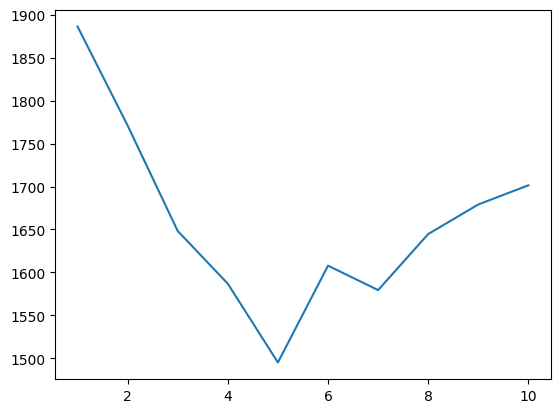

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Podemos graficar la evolución de la perplejidad con las épocas.
# Recordar que el valor de perplejidad del modelo trivial es el tamaño del vocabulario.
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.show()

In [ ]:
# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
model = keras.models.load_model('my_model.h5')


### Predicción de próxima palabra

In [ ]:
# Se puede usar gradio para probar el modelo
# Gradio es una herramienta muy útil para crear interfaces para ensayar modelos
# https://gradio.app/

!pip install -q gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.7/56.7 MB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.8/319.8 kB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.6/94.6 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.4/447.4 kB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 110.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/

In [ ]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')

    # Predicción softmax
    y_hat = np.argmax(model.predict(encoded)[0,-1,:])


    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text")

iface.launch(debug=True)

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://bc0aaf4ec9d7fa732b.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://bc0aaf4ec9d7fa732b.gradio.live


### Generación de secuencias

In [ ]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	  # generate a fixed number of words
    for _ in range(n_words):
		  # Tokenizamos
      encoded = tokenizer.texts_to_sequences([output_text])[0]

		  # Si tienen distinto largo
      encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		  # Predicción softmax
      y_hat = np.argmax(model.predict(encoded)[0,-1,:])

      # Vamos concatenando las predicciones
      out_word = ''

      # Debemos buscar en el vocabulario la palabra
      # que corresopnde al indice (y_hat) predicho por le modelo
      for word, index in tokenizer.word_index.items():
        if index == y_hat:
          out_word = word
          break

		  # Agrego las palabras a la frase predicha
      output_text += ' ' + out_word

    return output_text

In [ ]:
input_text='El profesor Lidenbrock tenía más razón que nadie para'

generate_seq(model, tok, input_text, max_length=max_context_size, n_words=10)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


'El profesor Lidenbrock tenía más razón que nadie para ser de la tierra no se había sido que no'

###  Beam search y muestreo aleatorio

In [ ]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=max_context_size):

    encoded = tok.texts_to_sequences([text])[0]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return tok.sequences_to_texts([seq])

In [ ]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp,mode):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  if mode == 'det':
    idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  elif mode == 'sto':
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo aleatorio
  else:
    raise ValueError(f'Wrong selection mode. {mode} was given. det and sto are supported.')

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input,temp=1,mode='det'):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = model.predict(encoded,verbose=0)[0,-1,:]

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp,
                                        mode)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = model.predict(input_update,verbose=0)[0,-1,:]

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp,
                                                        mode)

    return history_tokens

In [ ]:
# predicción con beam search.
# Se pueden camiar los modos entre 'det' (determinista) y
# 'sto' (estocástico)
# para el caso estocástico también se puede variar la temperatura
salidas = beam_search(model,num_beams=10,num_words=6,input="por eso el nombre de lidenbrock gozaba de gran",temp=5,mode='sto')

In [ ]:
# tenemos `num_beams` salidas ordenadas de mayor a menor likelihood
salidas.shape

(10, 16)

In [ ]:
# veamos las salidas
for i in range(5):
  print(decode(salidas[i]))

['por eso el nombre de lidenbrock gozaba de gran bastaron alejaban disminuido concluir techo recogerlo']
['por eso el nombre de lidenbrock gozaba de gran temibles posturas apolillarse grafitos y conjunto']
['por eso el nombre de lidenbrock gozaba de gran temibles posturas apolillarse grafitos y diluvium']
['por eso el nombre de lidenbrock gozaba de gran témpanos situación interesase ruhmkorff uniformidad visitarle']
['por eso el nombre de lidenbrock gozaba de gran témpanos situación podría invernáculo dimanaba oíale']


In [ ]:
# predicción con beam search.
# Se pueden camiar los modos entre 'det' (determinista) y
# 'sto' (estocástico)
# para el caso estocástico también se puede variar la temperatura
salidas = beam_search(model,num_beams=10,num_words=6,input="por eso el nombre de lidenbrock gozaba de gran",temp=0.5,mode='sto')

In [ ]:
# veamos las salidas
for i in range(5):
  print(decode(salidas[i]))

['por eso el nombre de lidenbrock gozaba de gran cantidad de las rocas de los']
['por eso el nombre de lidenbrock gozaba de gran cantidad de las rocas de las']
['por eso el nombre de lidenbrock gozaba de gran cantidad de las rocas de las']
['por eso el nombre de lidenbrock gozaba de gran cantidad de las rocas de la']
['por eso el nombre de lidenbrock gozaba de gran cantidad de las rocas de la']


##Conclusiones

Despues de todos las variaciones al modelo evaluado, no se llega a un entrenamiento satisfactorio, que se ve reflejado en las predicciones que arroja el modelo.

Habria que evaluar bien como se esta calculando la perplejidad ya que me llama la atención que al cambiar al optimizador Adam, el valor de perplejidad se modifique demasiado a pesar que el error no se ve tan afectado.

Por otro lado se puede intentar con mas modificaciones a la arquitectura para ver si converge mejor el modelo.

También usé los datos de validación como palabras sucesivas para que tengan coherencia dentro de un contexto pero aparentemente no ayudo mucho.

Otra cosa a probar es eliminar los acentos en la etapa de preprocesamiento y ver si tiene un mejor comportamiento el modelo.

Por ultimo pero no menos importante, es que quizas aunque el dataset es un libro y tiene una cantidad de terminos considerables, probablemente sigue siendo poco para poder darle referencia a un modelo sobre las complejidades semanticas de un idioma como el español, tranquilamente la seccion tomada en validacion puede tener secuencias de palabras que quizas nunca vio en entrenamiento, quizas tiene las mismas palabras pero en secuencias distintas que hacen que el signficado sea distinto, por lo que puede faltar muchas mas referencias para tener una respuesta adecuada.